In [1]:
import ot
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import random
from sklearn.metrics.pairwise import cosine_similarity

### Movies Datasets

In [2]:
Movies = pd.read_csv('../DATASETS/ml-20m/movies.csv')

In [3]:
Movies.shape

(27278, 3)

In [4]:
Movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
Movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB


In [6]:
Movies.isnull().any()

movieId    False
title      False
genres     False
dtype: bool

### Ratings Datasets

In [7]:
ratings_data = pd.read_csv('../DATASETS/ml-20m/ratings.csv', sep=',')
ratings_data.shape

(20000263, 4)

In [8]:
del ratings_data['timestamp']

In [9]:
ratings_data.describe()

,userId,movieId,rating
count,2.000026e+07,2.000026e+07,2.000026e+07
mean,6.904587e+04,9.041567e+03,3.525529e+00
std,4.003863e+04,1.978948e+04,1.051989e+00
min,1.000000e+00,1.000000e+00,5.000000e-01
25%,3.439500e+04,9.020000e+02,3.000000e+00
50%,6.914100e+04,2.167000e+03,3.500000e+00
75%,1.036370e+05,4.770000e+03,4.000000e+00
max,1.384930e+05,1.312620e+05,5.000000e+00


In [10]:
ratings_data.shape

(20000263, 3)

In [11]:
ratings_data.isnull().any()

userId     False
movieId    False
rating     False
dtype: bool

### Tags Datasets

In [12]:
tags_data = pd.read_csv('../DATASETS/ml-20m/tags.csv', sep=',')

In [13]:
tags_data.shape

(465564, 4)

In [14]:
tags_data.isnull().any()

userId       False
movieId      False
tag           True
timestamp    False
dtype: bool

In [15]:
# drop null rows
tags_data = tags_data.dropna()

In [16]:
tags_data.isnull().any()

userId       False
movieId      False
tag          False
timestamp    False
dtype: bool

In [17]:
# number of unique tags
unique_tags = tags_data['tag'].unique().tolist()
len(unique_tags)

38643

In [18]:
tags_data.tag

0           Mark Waters
1             dark hero
2             dark hero
3         noir thriller
4             dark hero
              ...      
465559          dragged
465560    Jason Bateman
465561           quirky
465562              sad
465563    rise to power
Name: tag, Length: 465548, dtype: object

In [19]:
Movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [20]:
ratings_data.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [21]:
tags_data.head()

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078


## Data visualization

In [22]:
#define a function that counts the number of times each genre appear:
def count_word(df, ref_col, liste):
    keyword_count = dict()
    for s in liste: keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split('|'):
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue
        for s in liste_keywords: 
            if pd.notnull(s): keyword_count[s] += 1
    # convert the dictionary in a list to sort the keywords  by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

In [23]:
#here we  make census of the genres:
genre_labels = set()
for s in Movies['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

In [24]:
genre_labels

{'(no genres listed)',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

In [25]:
#counting how many times each of genres occur:
keyword_occurences, dum = count_word(Movies, 'genres', genre_labels)
keyword_occurences

[['Drama', 13344],
 ['Comedy', 8374],
 ['Thriller', 4178],
 ['Romance', 4127],
 ['Action', 3520],
 ['Crime', 2939],
 ['Horror', 2611],
 ['Documentary', 2471],
 ['Adventure', 2329],
 ['Sci-Fi', 1743],
 ['Mystery', 1514],
 ['Fantasy', 1412],
 ['War', 1194],
 ['Children', 1139],
 ['Musical', 1036],
 ['Animation', 1027],
 ['Western', 676],
 ['Film-Noir', 330],
 ['(no genres listed)', 246],
 ['IMAX', 196]]

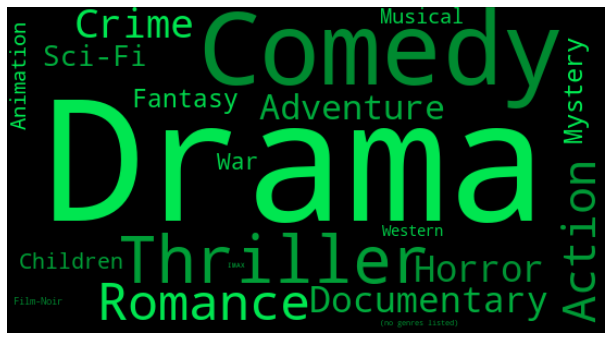

In [26]:
# Function that control the color of the words
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)


#Finally, the result is shown as a wordcloud:
words = dict()
trunc_occurences = keyword_occurences[0:50]
for s in trunc_occurences:
    words[s[0]] = s[1]
tone = 100 # define the color of the words
f, ax = plt.subplots(figsize=(14, 6))
wordcloud = WordCloud(width=550,height=300, background_color='black', 
                      max_words=1628,relative_scaling=0.7,
                      color_func = random_color_func,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

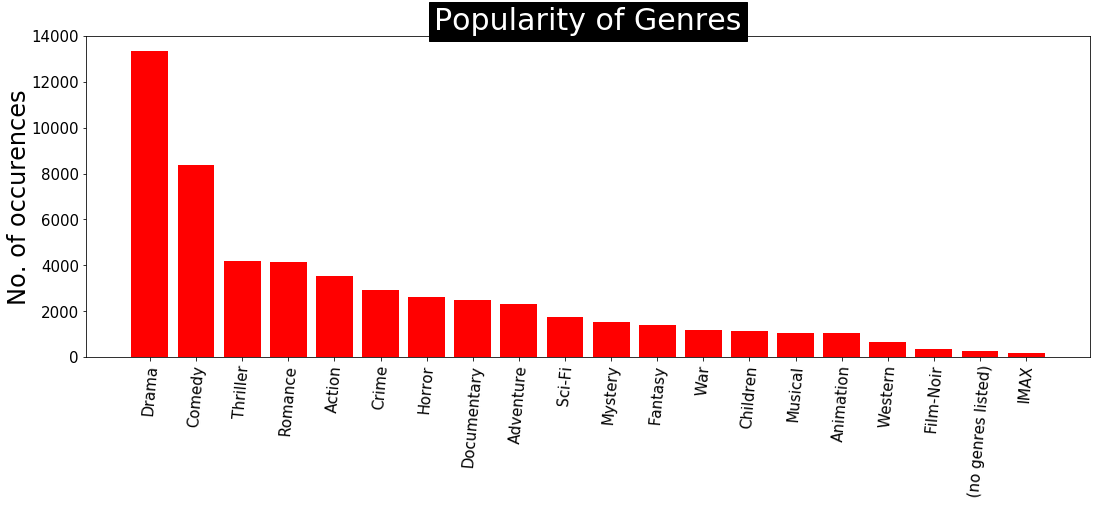

In [27]:
# lets display the same result in the histogram
fig = plt.figure(1, figsize=(18,13))
ax2 = fig.add_subplot(2,1,2)
y_axis = [i[1] for i in trunc_occurences]
x_axis = [k for k,i in enumerate(trunc_occurences)]
x_label = [i[0] for i in trunc_occurences]
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(x_axis, x_label)
plt.ylabel("No. of occurences", fontsize = 24, labelpad = 0)
ax2.bar(x_axis, y_axis, align = 'center', color='r')
plt.title("Popularity of Genres",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 30)
plt.show()

### Merging datasets

In [28]:
Movies_ratings_data = Movies.merge(ratings_data, on = 'movieId', how='inner')

In [29]:
Movies_ratings_data.head(10)

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3,4.0
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,6,5.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8,4.0
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10,4.0
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,11,4.5
5,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,12,4.0
6,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,13,4.0
7,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,14,4.5
8,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,16,3.0
9,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,19,5.0




# Problème jouet

## Exemple 1

####  Proposed model

$U$ l'ensemble de $m$ users

$V$ l'ensemble de $n$ items which interact with the users in $U$, items in $V$ the interacted items 

$C$ l'ensemble des cold-starts items

$R \in \mathbb{R}^{nxm}$ user's interaction matrix

In [30]:
### soit un jeu de donné

In [31]:
d_test = Movies_ratings_data.iloc[[1, 49994, 1005005, 3555555, 100000]]
d_test = d_test.reset_index(drop=True)
d_test

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,6,5.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1876,2.5
2,150,Apollo 13 (1995),Adventure|Drama|IMAX,6287,3.0
3,533,"Shadow, The (1994)",Action|Adventure|Fantasy|Mystery,19231,4.0
4,6,Heat (1995),Action|Crime|Thriller,2310,3.0


#### 1 - Set of the interacted items, denoted V

In [32]:
V = []
for l_values in d_test['genres'].str.split('|'):
    V = list(set(V) | set(l_values))
            
print("Le nombre des items d'interaction est : ", len(V))
print("L'ensemble V:\n", V)

Le nombre des items d'interaction est :  11
L'ensemble V:
 ['Mystery', 'Animation', 'Adventure', 'IMAX', 'Children', 'Fantasy', 'Comedy', 'Crime', 'Drama', 'Thriller', 'Action']


In [33]:
genreItm = []
for s in Movies['genres'].str.split('|').values:
    genreItm = list(set(genreItm) | set(s)) 

In [34]:
print("Le nombre de tous des items (avec ou sans interaction est : ", len(genreItm))

Le nombre de tous des items (avec ou sans interaction est :  20


#### Matrix R: interaction users and items

In [35]:
# nombre d'utilisateur
m = len(d_test['userId'])
# nombre d'items d'interaction
n = len(V)

In [36]:
d_test['genres'].str.split('|')[0]

['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy']

In [37]:
R_np = np.zeros((m, n))
u_interact = []
for l_users in range(m):
    l_usr_inter = d_test['genres'].str.split('|')[l_users]
    for i in l_usr_inter:
        for j in range(n):
            if i == V[j]:
                R_np[l_users, j] = 1

In [38]:
R_np

array([[0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1.]])

In [39]:
R = pd.DataFrame(R_np, dtype=bool, columns=V, index=list(d_test.movieId))
R = R.rename_axis('userId')

In [40]:
R

,Mystery,Animation,Adventure,IMAX,Children,Fantasy,Comedy,Crime,Drama,Thriller,Action
userId,,,,,,,,,,,
1,False,True,True,False,True,True,True,False,False,False,False
2,False,False,True,False,True,True,False,False,False,False,False
150,False,False,True,True,False,False,False,False,True,False,False
533,True,False,True,False,False,True,False,False,False,False,True
6,False,False,False,False,False,False,False,True,False,True,True


#### 2 - Cold-start items

In [41]:
C = [element for element in genreItm if element not in V]

In [42]:
print("Le nombre des cold-start items est : ", len(C))
print("L'ensemble C:\n", C)

Le nombre des cold-start items est :  9
L'ensemble C:
 ['War', 'Documentary', 'Western', 'Horror', 'Romance', 'Sci-Fi', 'Film-Noir', '(no genres listed)', 'Musical']


## Exemple 2

In [43]:
toystory = (Movies_ratings_data[Movies_ratings_data.title == 'Toy Story (1995)']).head(3)
jumanji = (Movies_ratings_data[Movies_ratings_data.title == 'Jumanji (1995)']).head(1)
shadow = (Movies_ratings_data[Movies_ratings_data.title =='Shadow, The (1994)']).head(1)
powder = (Movies_ratings_data[Movies_ratings_data.title =='Powder (1995)']).head(2)
sabrina = (Movies_ratings_data[Movies_ratings_data.title =='Sabrina (1995)']).head(2)

In [44]:
d_test2 = toystory.append(jumanji, sort=True)
d_test2 = d_test2.append(shadow, sort=True)
d_test2 = d_test2.append(powder, sort=True)
d_test2 = d_test2.append(sabrina, sort=True)

In [45]:
d_test2 = d_test2.reset_index(drop=True)
d_test2

,genres,movieId,rating,title,userId
0,Adventure|Animation|Children|Comedy|Fantasy,1,4.0,Toy Story (1995),3
1,Adventure|Animation|Children|Comedy|Fantasy,1,5.0,Toy Story (1995),6
2,Adventure|Animation|Children|Comedy|Fantasy,1,4.0,Toy Story (1995),8
3,Adventure|Children|Fantasy,2,3.5,Jumanji (1995),1
4,Action|Adventure|Fantasy|Mystery,533,3.0,"Shadow, The (1994)",29
5,Drama|Sci-Fi,24,3.0,Powder (1995),3
6,Drama|Sci-Fi,24,3.0,Powder (1995),7
7,Comedy|Romance,7,5.0,Sabrina (1995),6
8,Comedy|Romance,7,3.0,Sabrina (1995),7


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fac5d1602b0>],
      dtype=object)

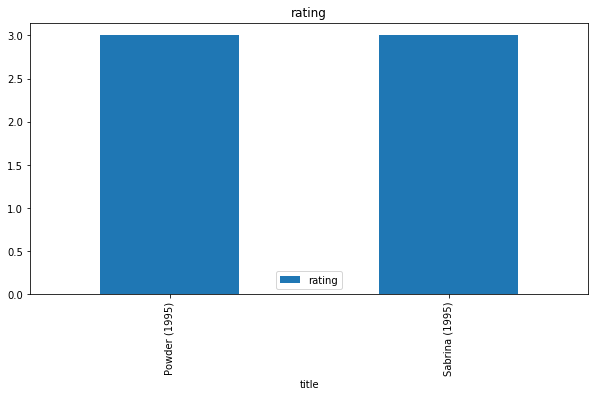

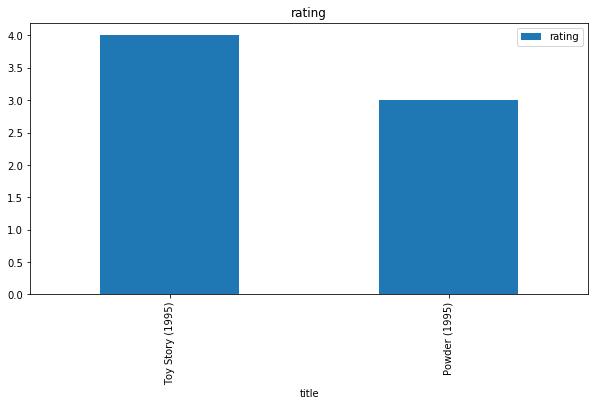

In [46]:
(d_test2[d_test2.userId == 7]).plot(kind='bar',x='title',y='rating',subplots=True, figsize=((10,5)))
(d_test2[d_test2.userId == 3]).plot(kind='bar',x='title',y='rating',subplots=True, figsize=((10,5))) 

### NEW EXEMPLE

In [57]:
Movies_test = Movies.head(5)

In [58]:
genre_test = set()

In [59]:
for s in Movies_test['genres'].str.split('|').values:
    genre_test = genre_test.union(set(s))

In [60]:
genre_test = list(genre_test)

In [61]:
m = len(Movies_test.movieId)
n = len(genre_test)
m

5

In [63]:
A = np.zeros((m, n))
for i in range(m):
    s = Movies_test.genres.str.split('|').values[i]
    for x in s:
        for j in range(n):
            if x == genre_test[j]:
                A[i][j] += 1

In [65]:
A

array([[1., 1., 1., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 1.],
       [0., 0., 0., 1., 1., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.]])

In [66]:
genre_test

['Children', 'Fantasy', 'Animation', 'Romance', 'Drama', 'Adventure', 'Comedy']

In [67]:
M = A.T.dot(A) 

In [68]:
M

array([[2., 2., 1., 0., 0., 2., 1.],
       [2., 2., 1., 0., 0., 2., 1.],
       [1., 1., 1., 0., 0., 1., 1.],
       [0., 0., 0., 2., 1., 0., 2.],
       [0., 0., 0., 1., 1., 0., 1.],
       [2., 2., 1., 0., 0., 2., 1.],
       [1., 1., 1., 2., 1., 1., 4.]])

### Visualization tags

In [69]:
rating_mean= ratings_data.groupby(['movieId'], as_index = False, sort = False).mean().rename(columns = {'rating': 'rating_mean'})[['movieId','rating_mean']]
adjusted_ratings = pd.merge(ratings_data,rating_mean,on = 'movieId', how = 'left', sort = False)

In [70]:
adjusted_ratings['rating_adjusted']=adjusted_ratings['rating']-adjusted_ratings['rating_mean']

In [71]:
adjusted_ratings.loc[adjusted_ratings['rating_adjusted'] == 0, 'rating_adjusted'] = 1e-8

In [72]:
adjusted_ratings

,userId,movieId,rating,rating_mean,rating_adjusted
0,1,2,3.5,3.211977,0.288023
1,1,29,3.5,3.952230,-0.452230
2,1,32,3.5,3.898055,-0.398055
3,1,47,3.5,4.053493,-0.553493
4,1,50,3.5,4.334372,-0.834372
...,...,...,...,...,...
20000258,138493,68954,4.5,4.038266,0.461734
20000259,138493,69526,4.5,2.938121,1.561879
20000260,138493,69644,3.0,3.387130,-0.387130
20000261,138493,70286,5.0,3.872481,1.127519
